# fNIRS to fMRI
In this notebook, we develop a pipeline for turning fMRI data into pseudo-fNIRS data, and we apply it to the NSD.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

## Install Libraries

In [3]:
# install libraries
!pip install numpy pmcx jdata bjdata matplotlib

In [4]:
## uncomment if FSL library not installed
# !sudo apt -qq install file
# !wget https://fsl.fmrib.ox.ac.uk/fsldownloads/fslinstaller.py
# !python3 fslinstaller.py

from pathlib import Path
fslpath = Path(os.getcwd()).parents[1].as_posix()+'/fsl'
os.environ["FSLDIR"] = fslpath
os.environ["FSLOUTPUTTYPE"] = "NIFTI_GZ"
os.environ["PATH"] += os.pathsep + os.path.join(fslpath, 'bin')
!. ${FSLDIR}/etc/fslconf/fsl.sh

## Place Optodes on Anatomical Image

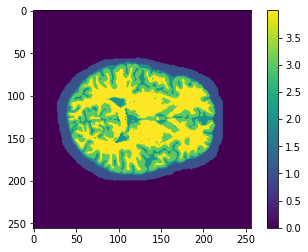

In [6]:
from subject import Subject

# define subject (id: '01' to '08') and create segmentation
subj = Subject(id='01')
subj.plot_segmentation()

Optodes already placed


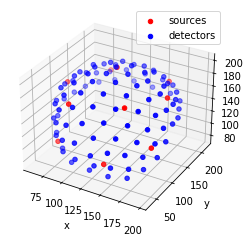

In [19]:
# place optodes on subject
geometry = subj.get_optodes(nsources=10, ndetectors=100)
subj.plot_optodes() 
# subj.save_optodes_json()

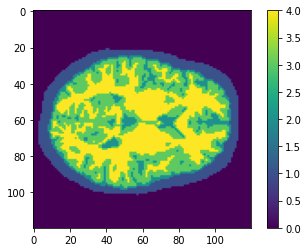

In [17]:
# transform anatomical segmentation into a given session (id: '21' to '30') and run (id: '01' to '12')
seg_transformed = subj.transform(sessionID='21', runID='01')
plt.imshow(seg_transformed[:,:,seg_transformed.shape[2]//2]); plt.colorbar(); plt.show()

transform s into functional space

In [20]:
from skimage import measure

def transform_geometry(subj, seg_transformed):
    # Anatomy positions
    detpos_anat = subj.geometry.detectors[:, :3]
    shapea = subj.segmentation.shape
    vertex_anat, _, _, _ = measure.marching_cubes(
        np.vstack([subj.segmentation, np.zeros([1, shapea[1], shapea[2]])]), level=0.5)
    centroid_anat = np.mean(vertex_anat, axis=0)

    # Functional positions
    shapef = seg_transformed.shape
    vertex_functional, _, _, _ = measure.marching_cubes(
        np.vstack([seg_transformed, np.zeros([1, shapef[1], shapef[2]])]), level=0.5)
    centroid_func = np.mean(vertex_functional, axis=0)

    # Vector from anatomic to functional centroid
    vec_anat2func = centroid_func - centroid_anat

    # Volume calculations
    seg_anat = subj.segmentation.copy()
    seg_anat[seg_anat > 0] = 1
    vol_anat = np.sum(seg_anat.flatten())

    seg_func = seg_transformed.copy()
    seg_func[seg_func > 0] = 1
    vol_func = np.sum(seg_func.flatten())

    # Scale calculation
    scale = (vol_func / vol_anat)**(1 / 3)

    # Transform points
    def transform_a2b(points_a, center_a, center_b, scale):
        return (points_a - center_a) * scale + center_b

    detpos_func = transform_a2b(detpos_anat, centroid_anat, centroid_func, scale)
    detpos_func = np.hstack([detpos_func, np.ones([detpos_func.shape[0], 1])])

    srcpos_func = transform_a2b(subj.geometry.sources, centroid_anat, centroid_func, scale)
    srcdir_func = subj.geometry.directions

    return detpos_func, srcpos_func, srcdir_func

# Usage
detpos, srcpos, srcdirs = transform_geometry(subj, seg_transformed)

Now that we've placed the optodes, it's good to do a sanity check. View 3D optode placement in browser gui by:
- In this directory go to `sanity_optode_placement.json`, entire file contents to clipboard (e.g. ctrl-a ctrl-c)
- Open [MCX cloud](https://mcx.space/cloud/) in browser
- Click JSON, delete the contents of that JSON file, replace it with your clip-board 
- Click Preview to view optode placement

# Forward solve

INPUT: 3D head mask is found in `data/subID/func/fmri/sessID/runID` 

OUTPUT: Measurement data in `data/subID/func/fnirs/sessID/runID`

In [15]:
import pmcx
pmcx.__version__   # print imported pmcx version number

'0.1.2'

In [16]:
pmcx.gpuinfo() # see gpu info

[{'name': 'NVIDIA A100-SXM4-40GB',
  'id': 1,
  'devcount': 1,
  'major': 8,
  'minor': 0,
  'globalmem': 42505273344,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1410000,
  'sm': 108,
  'core': 6912,
  'autoblock': 64,
  'autothread': 442368,
  'maxgate': 0}]

In [58]:
# TODO: properties might need revision
media_properties = [
    [0,       0,       1.0000,  1.0000], # background/air (not air pockets!)
    [0.0190,  7.8182,  0.8900,  1.3700], # scalp/skull
    [0.0040,  0.0090,  0.8900,  1.3700], # csf
    [0.0200,  9.0000,  0.8900,  1.3700], # gray matters
    [0.0800,  40.9000, 0.8400,  1.3700]] # white matters

media_properties_dict = {
    "air":[0,0,1,1],
    "skull":[0.0190,  7.8182,  0.8900,  1.3700],
    "csf":[0.0040,  0.0090,  0.8900,  1.3700],
    "gray matter":[0.0200,  9.0000,  0.8900,  1.3700],
    "white matter":[0.0800,  40.9000, 0.8400,  1.3700]
}

# prop = [[0,0,1,1],[0,0,g,n]]

n = 1.37 # index of refraction
g = 0.9 # anisotropy factor

i = 1

cfg = {
       'nphoton': 1000000,
       'vol': seg_transformed,
       'tstart':0,
       'tend': 5e-9,
       'tstep': 1e-10,
       'srcpos': sourcepos[i],
       'srcdir': sourcedir[i],
       'detpos': detpos_func,
       'prop': media_properties,
       'issavedet': True,
       }

In [60]:
import jdata as jd
import json

### JSON manipulation
# encode & compress vol
vol_encoded = jd.encode(
    np.asarray(seg_transformed + 0.5, dtype=np.uint8), {"compression": "zlib", "base64": 1}
)  # serialize volume
# manipulate binary str ing format so that it can be turned into json
vol_encoded["_ArrayZipData_"] = str(vol_encoded["_ArrayZipData_"])[2:-1]

with open("colin27.json") as f:
    json_inp = json.load(f)  # Load boilerplate json to dict
json_inp["Shapes"] = vol_encoded  # Replaced volume ("shapes") atribute
json_inp["Session"]["ID"] = "random"  # and model ID
# Make optode placement
sources_list = []
for s, d in zip(srcpos_func, srcdir_func):
    sources_list.append(
        {
            "Type": "pencil",
            "Pos": [s[0], s[1], s[2]],
            "Dir": [d[0], d[1], d[2], 0],
            "Param1": [0, 0, 0, 0],  # cargo cult, dont know what param1 and 2 does
            "Param2": [0, 0, 0, 0],
        }
    )
detectors_list = []
for d in detpos_func:
    detectors_list.append({"Pos": [d[0], d[1], d[2]], "R": d[3]})
json_inp["Optode"] = {
    "Source": sources_list[
        0
    ],  # For the json we just pick one source, just for mcx viz
    "Detector": detectors_list,
}
json_inp["Domain"]["Dim"] = [
    int(i) for i in seg_transformed.shape
]  # Set the spatial domain of Simulation
with open("sanity.json", "w") as f:
    json.dump(json_inp, f, indent=4)  # Write above changes to file
print(f"Saved to sanity.json")

In [61]:
res = pmcx.run(cfg)

nphoton: 1e+06
tstart: 0
tstep: 1e-10
tend: 5e-09
srcpos: [68.6625, 10.1428, 27.6037, 1]
srcdir: [-0.236413, 0.917555, 0.31969, 0]
issavedet: 1


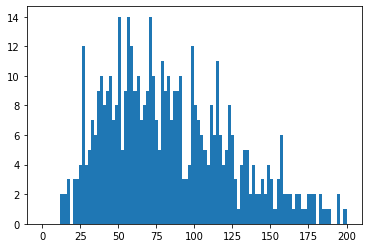

In [62]:
plt.hist(res['detp'][1], bins=100, range=[0,200])
plt.show()

In [63]:
import matplotlib.animation as animation

In [64]:
# Set up the figure
zidx = seg_transformed.shape[2] // 2
fig, ax = plt.subplots(figsize=(10, 10))

# Initial frame
im1 = ax.imshow(seg_transformed[:,:,zidx], animated=True, cmap='gray')
im2 = ax.imshow(np.log10(res['flux'][:,:,zidx, 0]), animated=True, alpha=0.5, cmap='jet')

# Update function
def update(t):
    im2.set_array(np.log10(res['flux'][:,:,zidx, t]))
    return im2,

# Create the animation object
ani = animation.FuncAnimation(fig, update, frames=res['flux'].shape[3], blit=True)

# Save the animation
ani.save('visualization.mp4', writer='ffmpeg', fps=5)

plt.close(fig)

<ipython-input-64-5cc35a1958c7>:7: RuntimeWarning: divide by zero encountered in log10
  im2 = ax.imshow(np.log10(res['flux'][:,:,zidx, 0]), animated=True, alpha=0.5, cmap='jet')
<ipython-input-64-5cc35a1958c7>:11: RuntimeWarning: divide by zero encountered in log10
  im2.set_array(np.log10(res['flux'][:,:,zidx, t]))
<ipython-input-64-5cc35a1958c7>:11: RuntimeWarning: divide by zero encountered in log10
  im2.set_array(np.log10(res['flux'][:,:,zidx, t]))


In [65]:
import nibabel as nib
fmri = nib.load('data/sub01/func/fmri/sess21/run01/sub-01_ses-nsd21_task-nsdcore_run-01_bold.nii.gz').get_fdata()

(120, 120, 84, 188)

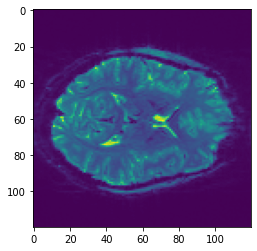

In [67]:
plt.imshow(fmri[:,:,42,0]); plt.show()

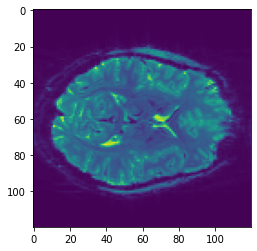

In [70]:
fmri_avg = np.average(fmri, axis=3)
plt.imshow(fmri_avg[:,:,42]); plt.show()

In [98]:
bold_percent = 1 + (fmri - fmri_avg[:,:,:,np.newaxis]) / fmri_avg[:,:,:,np.newaxis]

<ipython-input-98-3ce0265d6d50>:1: RuntimeWarning: invalid value encountered in divide
  bold_percent = 1 + (fmri - fmri_avg[:,:,:,np.newaxis]) / fmri_avg[:,:,:,np.newaxis]


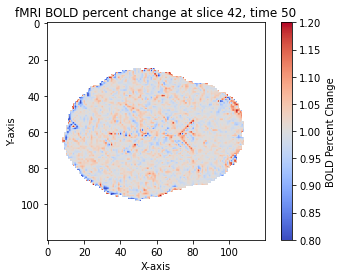

In [97]:
def plot_bold_percent(t, z=42):
    masked_array = np.ma.masked_where(seg_transformed[:,:,z] < 2, bold_percent[:,:,z,t])
    masked_array = np.clip(masked_array, 0.8, 1.2)
    plt.imshow(masked_array, cmap='coolwarm')
    plt.colorbar(label='BOLD Percent Change')
    plt.title(f'fMRI BOLD percent change at slice {z}, time {t}')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()
plot_bold_percent(50)

In [137]:
def bold2optical(bold_change, seg_transformed):
    
    # 1. build baseline optical properties
    # optical_baseline should be of shape (2, x,y,z)
    newshape = (2, *seg_transformed.shape)
    optical_baseline = np.zeros(newshape)
    for idx, prop in enumerate(media_properties):
        # when seg_transformed == idx, optical_baseline[0] == prop[0], optical_baseline[1] == prop[1]
        optical_baseline[0][seg_transformed == idx] = prop[0] # mu_a
        optical_baseline[1][seg_transformed == idx] = prop[1] # mu_s
    

    # 2. build optical properties change
    optical_change = (bold_change - 1) * 0.20 + 1 # scientific scaling factor BOLD -> optical
    
    optical_vol = optical_baseline[..., np.newaxis]  # Adds a new axis along the last dimension

    # Now fill in the new dimension
    optical_vol = np.repeat(optical_vol, bold_change.shape[-1], axis=-1)
    print(optical_vol.shape)

    # print(optical_change.shape, seg_transformed.shape)
    for i in range(optical_vol.shape[-1]):
        optical_vol[0,:,:,:,i] *= optical_change[:,:,:,i] * (seg_transformed > 2) # white and grey matter
    
    # put back the removed properties 
    for i in [0,1,2]:
        optical_vol[0,:,:,:][seg_transformed == i] = media_properties[i][0]

    return optical_vol.astype(np.float32), optical_baseline.astype(np.float32)
optical_vol, optical_baseline = bold2optical(bold_percent, seg_transformed)



(2, 120, 120, 84, 188)


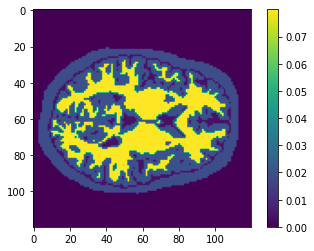

In [138]:
plt.imshow(optical_baseline[0,:,:,42]); plt.colorbar(); plt.show()

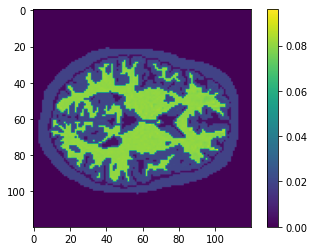

In [139]:
plt.imshow(optical_vol[0,:,:,42,2]); plt.colorbar(); plt.show()

In [110]:
a = np.array([1,2,3])
np.expand_dims(a, axis=0)

array([[1, 2, 3]])

In [99]:
for time

0 4
1 5


In [141]:
n = 1.37 # index of refraction
g = 0.9 # anisotropy factor

i = 1

res = []

for time_idx in range(optical_vol.shape[-1]):
       cfg = {
              'nphoton': 1000000,
              'vol': optical_vol[..., time_idx],
              'tstart':0,
              'tend': 5e-9,
              'tstep': 1e-10,
              'srcpos': srcpos_func[i],
              'srcdir': srcdir_func[i],
              'detpos': detpos_func,
              'prop': [
                     [0,0,1,1],
                     [0,0,g,n]
              ],
              'issavedet': True,
              }
       newresult = pmcx.run(cfg)
       res.append(newresult)
       print("time_idx", time_idx)
       print()

nphoton: 1e+06
tstart: 0
tstep: 1e-10
tend: 5e-09


srcpos: [68.6625, 10.1428, 27.6037, 1]
srcdir: [-0.236413, 0.917555, 0.31969, 0]
issavedet: 1
time_idx 0

nphoton: 1e+06
tstart: 0
tstep: 1e-10
tend: 5e-09
srcpos: [68.6625, 10.1428, 27.6037, 1]
srcdir: [-0.236413, 0.917555, 0.31969, 0]
issavedet: 1
time_idx 1

nphoton: 1e+06
tstart: 0
tstep: 1e-10
tend: 5e-09
srcpos: [68.6625, 10.1428, 27.6037, 1]
srcdir: [-0.236413, 0.917555, 0.31969, 0]
issavedet: 1
time_idx 2

nphoton: 1e+06
tstart: 0
tstep: 1e-10
tend: 5e-09
srcpos: [68.6625, 10.1428, 27.6037, 1]
srcdir: [-0.236413, 0.917555, 0.31969, 0]
issavedet: 1
time_idx 3

nphoton: 1e+06
tstart: 0
tstep: 1e-10
tend: 5e-09
srcpos: [68.6625, 10.1428, 27.6037, 1]
srcdir: [-0.236413, 0.917555, 0.31969, 0]
issavedet: 1
time_idx 4

nphoton: 1e+06
tstart: 0
tstep: 1e-10
tend: 5e-09
srcpos: [68.6625, 10.1428, 27.6037, 1]
srcdir: [-0.236413, 0.917555, 0.31969, 0]
issavedet: 1
time_idx 5

nphoton: 1e+06
tstart: 0
tstep: 1e-10
tend: 5e-09
srcpos: [68.6625, 10.1428, 27.6037, 1]
srcdir: [-0.236413, 0.917